In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('drive/MyDrive/2022 EECS 6691/Final Project')

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn.init as init

In [4]:
traced_neurons_new = pd.read_csv('exported-traced-adjacencies/traced-neurons.csv')
traced_neurons_new['type'].nunique()

4741

In [5]:
traced_neurons = pd.read_csv('exported-traced-adjacencies/traced-neurons.csv')
traced_roi_connections = pd.read_csv('exported-traced-adjacencies/traced-roi-connections.csv')
traced_total_connections = pd.read_csv('exported-traced-adjacencies/traced-total-connections.csv')

In [ ]:
traced_total_connections

,bodyId_pre,bodyId_post,weight
0,5813054846,5813020143,1
1,5813054846,2215550458,1
2,5813054846,1448575109,1
3,5813054846,1223388206,1
4,5813054846,1913403687,1
...,...,...,...
3413155,453794660,481070027,1
3413156,453794660,423792440,2
3413157,453794660,455172836,1
3413158,453794660,388975834,3


In [ ]:
traced_neurons

,bodyId,instance,type
0,5813054846,PVM03y_pct(PVM03)_R,PVM03y_pct
1,1479492693,AVL13t_pct(AVL13)_R,AVL13t_pct
2,5812982999,KCg,KCg
3,1720300275,AVL04v_d_pct(AVL04)_R,AVL04v_d_pct
4,5813060766,PDL14m_a_pct(PDL14)_R,PDL14m_a_pct
...,...,...,...
21658,583132200,(ADM01)_L,NaN
21659,5813098080,ADL01os_pct(ADL01)_R,ADL01os_pct
21660,1948478919,AVL14t_pct(AVL14)_R,AVL14t_pct
21661,604061479,AVL12j_pct(AVL12)_R,AVL12j_pct


In [6]:
# clean neurons
for index, row in traced_neurons.iterrows():
    if pd.isnull(row['type']):
        traced_neurons.drop(index, inplace=True)


In [ ]:
traced_neurons

,bodyId,instance,type
0,5813054846,PVM03y_pct(PVM03)_R,PVM03y_pct
1,1479492693,AVL13t_pct(AVL13)_R,AVL13t_pct
2,5812982999,KCg,KCg
3,1720300275,AVL04v_d_pct(AVL04)_R,AVL04v_d_pct
4,5813060766,PDL14m_a_pct(PDL14)_R,PDL14m_a_pct
...,...,...,...
21657,5812988128,LC9(PLBDL3)_R,LC9
21659,5813098080,ADL01os_pct(ADL01)_R,ADL01os_pct
21660,1948478919,AVL14t_pct(AVL14)_R,AVL14t_pct
21661,604061479,AVL12j_pct(AVL12)_R,AVL12j_pct


In [7]:
num_nodes = 18837

In [8]:
unique_instances = traced_neurons['instance'].unique()
print(len(unique_instances))
unique_types = traced_neurons['type'].unique()
print(len(unique_types))

6068
4741


In [9]:
bodyIds = traced_neurons['bodyId'].unique()

In [10]:
# clean traced_neuron_connections
# for index, row in traced_total_connections.iterrows():
#     if row['bodyId_pre'] not in bodyIds or row['bodyId_post'] not in bodyIds:
#         traced_total_connections.drop(index, inplace=True)
traced_total_connections = traced_total_connections.loc[traced_total_connections['bodyId_pre'].isin(bodyIds) & traced_total_connections['bodyId_post'].isin(bodyIds)]
# x.loc[x['name'].isin(names), 'score'].sum()


In [66]:
traced_neurons.head()

,bodyId,instance,type
0,5813054846,PVM03y_pct(PVM03)_R,PVM03y_pct
1,1479492693,AVL13t_pct(AVL13)_R,AVL13t_pct
2,5812982999,KCg,KCg
3,1720300275,AVL04v_d_pct(AVL04)_R,AVL04v_d_pct
4,5813060766,PDL14m_a_pct(PDL14)_R,PDL14m_a_pct


In [11]:
# assign indexes
label_idx_dict = {}
for i, label in enumerate(unique_types):
    label_idx_dict[label] = i

In [12]:
labels = [label_idx_dict[label] for label in traced_neurons['type'].values]

In [ ]:
len(labels)

18837

In [13]:
# get number of neuron types
num_classes = traced_neurons['type'].nunique()
print(num_classes)

4741


In [ ]:
traced_total_connections

,bodyId_pre,bodyId_post,weight
0,5813054846,5813020143,1
1,5813054846,2215550458,1
2,5813054846,1448575109,1
3,5813054846,1223388206,1
4,5813054846,1913403687,1
...,...,...,...
3413155,453794660,481070027,1
3413156,453794660,423792440,2
3413157,453794660,455172836,1
3413158,453794660,388975834,3


In [14]:
# assign indexes to bodyIds
bodyIds = traced_neurons['bodyId'].unique()
bodyIds = sorted(bodyIds)

In [15]:
bodyId_idx_dict = {}
for i, bodyId in enumerate(bodyIds):
    bodyId_idx_dict[bodyId] = i

In [16]:
def bodyId_to_idx(bodyId):
    if type(bodyIds) == list:
        return bodyIds.index(bodyId)
    elif type(bodyIds) == np.array:
        return bodyIds.where(bodyId)

In [17]:
## add self loops
self_loop_array = np.zeros((num_nodes, 3))
for i, bodyId in enumerate(bodyId_idx_dict.keys()):
    self_loop_array[i, 0] = bodyId
    self_loop_array[i, 1] = bodyId
    self_loop_array[i, 2] = 1
self_loop_df = pd.DataFrame(self_loop_array, columns = ['bodyId_pre', 'bodyId_post', 'weight'])

traced_total_connections = pd.concat([traced_total_connections, self_loop_df])

In [18]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import torch.nn as nn
import torch.nn.functional as F

# import dgl
# import dgl.data
# from dgl.utils import expand_as_pair
# import dgl.function as fn

import timeit

In [19]:
bodyId_idx_dict = {}
for i, bodyId in enumerate(bodyIds):
    bodyId_idx_dict[bodyId] = i

In [20]:
start = timeit.default_timer()
pre_indexes = np.vectorize(bodyId_idx_dict.get)(traced_total_connections['bodyId_pre'].values)
end = timeit.default_timer()
print(f"time elapsed: {end - start} s")
# from https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key

time elapsed: 4.5276179019999745 s


In [ ]:
print(max(pre_indexes))

21662


In [21]:
start = timeit.default_timer()
post_indexes = np.vectorize(bodyId_idx_dict.get)(traced_total_connections['bodyId_post'].values)
end = timeit.default_timer()
print(f"time elapsed: {end - start} s")
# from https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key

time elapsed: 5.350169486999903 s


In [22]:
start = timeit.default_timer()
edge_weights = traced_total_connections['weight'].values
end = timeit.default_timer()
print(f"time elapsed: {end - start} s")

time elapsed: 0.0002875220000078116 s


In [46]:
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [23]:
# how long to add self loops
# for i in range(num_nodes):
#     np.append(pre_indexes, i)
#     np.append(post_indexes, i)

pre_indexes = np.concat([pre_indexes, np.array(list(range(num_nodes)))])
post_indexes = np.concat([post_indexes, np.array(list(range(num_nodes)))])
# 3 minutes

AttributeError: ignored

In [24]:
start = timeit.default_timer()
graph = dgl.graph((pre_indexes, post_indexes), num_nodes=num_nodes)
end = timeit.default_timer()
print(f"time elapsed: {end-start}s")

NameError: ignored

In [ ]:
graph

Graph(num_nodes=21663, num_edges=3413160,
      ndata_schemes={}
      edata_schemes={})

In [ ]:
import torch

In [ ]:
A = torch.eye(num_nodes)

In [25]:
# raw adjacency matrix

# start with self-loops
A = np.eye(num_nodes) 

In [26]:
for pre, post, weight in zip(pre_indexes, post_indexes, edge_weights):
    # MxN, N is pre, M is post
    if pre in bodyIds and post in bodyIds:
        A[post, pre] += weight

In [27]:
# normalize columns with L1 norm
for j in range(A.shape[0]):
    A[:, j] = A[:, j] / sum(A[:, j]) 

In [ ]:
print(sum(A[:, 1710]))
print(sum(A[1710, :])) # note: normalizing should prevent APL dominance from bias...?

1.0
1.0


In [ ]:
A[]

In [ ]:
sum(A[:, 0])

1.0

In [ ]:
# convert to tesnor
A_tensor = torch.tensor(A)

In [28]:
# get indegree
in_degree = np.zeros(num_nodes)
out_degree = np.zeros(num_nodes)

for pre, post, weight in zip(pre_indexes, post_indexes, edge_weights):

    # if pre in bodyIds and post in bodyIds:
        in_degree[post] += weight
        out_degree[pre] += weight

In [ ]:
max(in_degree)

0.0

In [ ]:
max(out_degree)

0.0

## Getting metadata

## Metadata for synapses

In [29]:
csv_synapses = pd.read_csv('data-raw/hemibrain_all_neurons_metrics_polypre_centrifugal_synapses.csv')

<ipython-input-29-b48670fde3be>:1: DtypeWarning: Columns (8,36) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_synapses = pd.read_csv('data-raw/hemibrain_all_neurons_metrics_polypre_centrifugal_synapses.csv')


In [82]:
traced_neurons['type'].value_counts()[:20]

KCab-sc         828
KCg             701
LC10            448
MC61            346
KCa'b'          336
LC12            226
LC17            186
olfactory LN    175
LC9             135
MC64            121
PFNp_a          115
PFNp_b          114
LPC1            113
LLPC3           110
LC18            103
LLPC2c           92
LPLC2            85
LC16             83
LC13             81
LC21             75
Name: type, dtype: int64

Text(0, 0.5, 'number of occurrences')

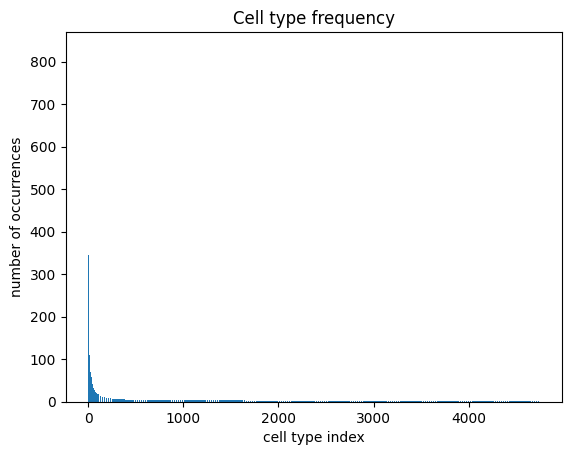

In [88]:
plt.bar(range(num_classes), traced_neurons['type'].value_counts())
plt.title('Cell type frequency')
plt.xlabel('cell type index')
plt.ylabel('number of occurrences')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'KCab-sc'),
  Text(1, 0, 'KGg'),
  Text(2, 0, 'LC10'),
  Text(3, 0, 'MC61'),
  Text(4, 0, "KCa'b'"),
  Text(5, 0, 'LC12'),
  Text(6, 0, 'LC17'),
  Text(7, 0, 'olfactory LN'),
  Text(8, 0, 'LC9'),
  Text(9, 0, 'MC64'),
  Text(10, 0, 'PFNp_a'),
  Text(11, 0, 'PFNp_b'),
  Text(12, 0, 'LPLC1'),
  Text(13, 0, 'LLPC3'),
  Text(14, 0, 'LC18'),
  Text(15, 0, 'LLPC2c'),
  Text(16, 0, 'LPLC2'),
  Text(17, 0, 'LC16'),
  Text(18, 0, 'LC13'),
  Text(19, 0, 'LC21'),
  Text(20, 0, 'average')])

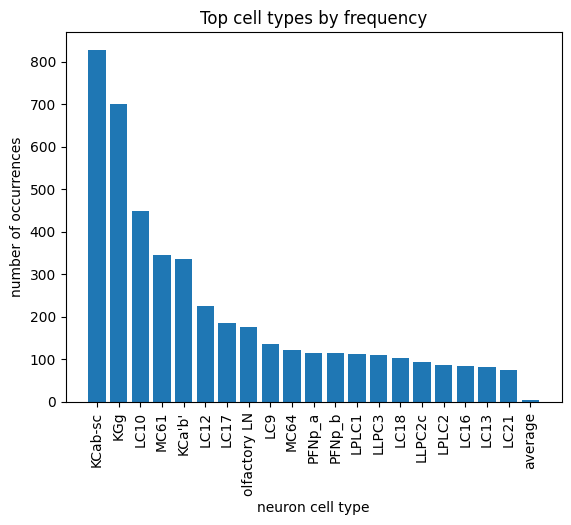

In [85]:
plt.bar(['KCab-sc', 'KGg', 'LC10', 'MC61', "KCa'b'", 'LC12', 'LC17', 'olfactory LN', 'LC9', 'MC64', 'PFNp_a', 'PFNp_b', 'LPLC1', 'LLPC3', 'LC18', 'LLPC2c', 'LPLC2', 'LC16', 'LC13', 'LC21', 'average'], list(traced_neurons['type'].value_counts()[:20]) + [3.973])
plt.xlabel('neuron cell type')
plt.ylabel('number of occurrences')
plt.title('Top cell types by frequency')
plt.xticks(rotation=90)

In [77]:
np.mean(traced_neurons['type'].value_counts())

3.973212402446741

In [ ]:
csv_synapses.columns

Index(['cellBodyFiber', 'bodyid', 'pre', 'post', 'upstream', 'downstream',
       'status', 'statusLabel', 'cropped', 'name', 'type', 'voxels', 'notes',
       'soma', 'ito_lee_lineage', 'ito_lee_hemilineage', 'hartenstein_lineage',
       'hartenstein_hemilineage', 'putative.classic.transmitter',
       'putative.other.transmitter', 'FAFB.match', 'FAFB.match.quality',
       'layer', 'ct.layer', 'overlap_locality', 'position', 'point', 'X', 'Y',
       'Z', 'soma.edit', 'cut', 'truncated', 'manual_edit', 'splittable',
       'skeletonization', 'checked', 'user', 'time', 'note', 'priority',
       'edited.cable', 'orig.soma', 'orig.cut', 'soma.checked', 'cbf',
       'total_outputs', 'total_inputs', 'axon_outputs', 'dend_outputs',
       'axon_inputs', 'dend_inputs', 'total_outputs_density',
       'total_inputs_density', 'axon_outputs_density', 'dend_outputs_density',
       'axon_inputs_density', 'dend_inputs_density', 'total_length',
       'axon_length', 'dend_length', 'pd_length',

In [ ]:
# determine which columns have NaN
for col in csv_synapses.columns:
    # print(col, set(type(entry) for entry in csv_synapses[col].unique()))
    # print(col, csv_synapses[col].isnull().values.any(), set(type(entry) for entry in csv_synapses[col].unique()))
    if not csv_synapses[col].isnull().values.any():
        print(col, set(type(entry) for entry in csv_synapses[col].unique()))

bodyid {<class 'numpy.int64'>}
pre {<class 'numpy.int64'>}
post {<class 'numpy.int64'>}
upstream {<class 'numpy.int64'>}
downstream {<class 'numpy.int64'>}
status {<class 'str'>}
statusLabel {<class 'str'>}
voxels {<class 'numpy.int64'>}
soma {<class 'numpy.bool_'>}
position {<class 'numpy.int64'>}
X {<class 'numpy.float64'>}
Y {<class 'numpy.float64'>}
Z {<class 'numpy.float64'>}
soma.edit {<class 'str'>}
checked {<class 'str'>, <class 'int'>}
time {<class 'str'>}
soma.checked {<class 'numpy.bool_'>}
total_outputs {<class 'numpy.int64'>}
total_inputs {<class 'numpy.int64'>}
axon_outputs {<class 'numpy.int64'>}
dend_outputs {<class 'numpy.int64'>}
axon_inputs {<class 'numpy.int64'>}
dend_inputs {<class 'numpy.int64'>}
total_outputs_density {<class 'numpy.float64'>}
total_inputs_density {<class 'numpy.float64'>}
total_length {<class 'numpy.float64'>}


In [ ]:
csv_synapses['total_outputs']/sum(csv_synapses['total_outputs']) # how to normalize

0        0.000017
1        0.000023
2        0.000017
3        0.000042
4        0.000070
           ...   
24688    0.000015
24689    0.000012
24690    0.000005
24691    0.000021
24692    0.000037
Name: total_outputs, Length: 24693, dtype: float64

In [ ]:
# find quantitative features
# too much NaN: overlap_locality, axon_outputs_density
csv_synapses[['pre', 'post', 'upstream', 'downstream', 'total_outputs', 'total_inputs',  'total_outputs_density', 'total_inputs_density', 'total_length']]

,pre,post,upstream,downstream,total_outputs,total_inputs,total_outputs_density,total_inputs_density,total_length
0,233,411,411,742,737,411,1.165768,0.650109,632.201495
1,103,114,114,959,959,112,1.085772,0.126806,883.242118
2,219,646,646,710,710,645,0.747531,0.679095,949.793992
3,339,1017,1017,1804,1800,1008,0.985150,0.551684,1827.133769
4,392,4143,4143,2972,2972,4122,0.398117,0.552166,7465.149818
...,...,...,...,...,...,...,...,...,...
24688,88,189,189,634,634,188,0.571944,0.169599,1108.500157
24689,193,1395,1395,514,509,1389,0.196862,0.537213,2585.566400
24690,45,325,325,212,205,325,0.152806,0.242253,1341.570095
24691,139,173,173,872,872,172,1.696385,0.334608,514.034171


In [ ]:
set(type(entry) for entry in csv_synapses['dend_length'].unique())

{numpy.float64}

In [ ]:
set(type(entry) for entry in csv_synapses['pd_length'].unique())

{numpy.float64}

In [ ]:
set(type(entry) for entry in csv_synapses['dend_length'].unique())

In [ ]:
csv_synapses['soma'].unique()

array([False,  True])

In [ ]:
csv_synapses['pre'].unique()

array([  233,   103,   219, ..., 17628,  4957,  7499])

In [ ]:
max(csv_synapses['post'])
# proof that 'post' here returns to the node count, not the postsynaptic-bodyId of a synapse

127148

In [ ]:
csv_synapses[['bodyid', 'pre', 'post', 'upstream', 'downstream', 'name', 'type']]

,bodyid,pre,post,upstream,downstream,name,type
0,5812980768,233,411,411,742,KCab-s_R,KCab-s
1,480918798,103,114,114,959,LHPD3a4_c_R,LHPD3a4_c
2,599674785,219,646,646,710,KCab-m_R,KCab-m
3,358424052,339,1017,1017,1804,FB8G_L,FB8G
4,326530038,392,4143,4143,2972,SMP505_R,SMP505
...,...,...,...,...,...,...,...
24688,1535427917,88,189,189,634,WED040_a_R,WED040_a
24689,1598296804,193,1395,1395,514,PVLP023_R,PVLP023
24690,5812994890,45,325,325,212,PS224_R,PS224
24691,1753034787,139,173,173,872,LC18,LC18


In [ ]:
np.array([0, 1, 2, 3, 4,]).sear(0)

AttributeError: ignored

In [ ]:
csv_synapses['type'].nunique()

5606

In [ ]:
traced_neurons['type'].nunique()

4741

In [30]:
# get xyz
xyz = np.zeros((num_nodes, 3))
for index, row in csv_synapses.iterrows():
    if row['bodyid'] in bodyIds:
        idx = bodyId_to_idx(row['bodyid'])
        xyz[idx, :] = row[['X', 'Y', 'Z']]

In [ ]:
bodyIds

[200326126,
 202916528,
 203253072,
 203257652,
 203594169,
 203594175,
 203598499,
 203598504,
 203598542,
 203598557,
 203931040,
 204613133,
 204962646,
 205299889,
 206555682,
 232513628,
 232513671,
 233105330,
 233877926,
 234292899,
 235985275,
 236330337,
 236331138,
 262167456,
 262504004,
 262517074,
 262840563,
 263199096,
 263475451,
 263522664,
 263674097,
 264014957,
 264083994,
 264438143,
 264779403,
 264783939,
 264822904,
 264986706,
 265120223,
 265120324,
 265120424,
 265120467,
 265120589,
 265120597,
 265120677,
 265124786,
 265155147,
 265655867,
 266187342,
 266187383,
 266187477,
 266187480,
 266187532,
 266187559,
 266191395,
 266191407,
 266200011,
 266527996,
 266528044,
 266528078,
 266528086,
 266536576,
 266847236,
 266873389,
 266873401,
 266873591,
 267214250,
 267223027,
 267223104,
 267227062,
 267304783,
 267551639,
 267559575,
 267559665,
 267564140,
 267572587,
 267896359,
 267896360,
 268237554,
 268725517,
 270322941,
 294161385,
 294424196,
 294

In [ ]:
csv_synapses[['post', 'pre', 'bodyid']]

,post,pre,bodyid
0,411,233,5812980768
1,114,103,480918798
2,646,219,599674785
3,1017,339,358424052
4,4143,392,326530038
...,...,...,...
24688,189,88,1535427917
24689,1395,193,1598296804
24690,325,45,5812994890
24691,173,139,1753034787


In [ ]:
5812980768 in bodyIds

True

In [ ]:
csv_synapses[csv_synapses['bodyid'].isin(bodyIds)]

,cellBodyFiber,bodyid,pre,post,upstream,downstream,status,statusLabel,cropped,name,...,total_inputs_density,axon_outputs_density,dend_outputs_density,axon_inputs_density,dend_inputs_density,total_length,axon_length,dend_length,pd_length,segregation_index
0,PDL03,5812980768,233,411,411,742,Traced,Roughly traced,False,KCab-s_R,...,0.650109,1.955320,1.200554,0.990357,0.734604,632.201495,118.139233,238.223429,35.604968,0.001535
1,PDL13,480918798,103,114,114,959,Traced,Roughly traced,False,LHPD3a4_c_R,...,0.126806,2.580372,0.191259,0.234836,0.205426,883.242118,353.437411,141.169837,25.929089,0.090287
2,PDL02,599674785,219,646,646,710,Traced,Roughly traced,False,KCab-m_R,...,0.679095,1.501290,0.249419,1.162849,0.657951,949.793992,345.702765,232.540022,238.696006,0.037496
3,AVM10,358424052,339,1017,1017,1804,Traced,Roughly traced,False,FB8G_L,...,0.551684,1.719117,0.248872,0.869320,0.325608,1827.133769,973.173907,482.174694,110.849331,0.015147
4,PDM22,326530038,392,4143,4143,2972,Traced,Roughly traced,False,SMP505_R,...,0.552166,0.869836,0.198318,0.637777,0.680308,7465.149818,2602.790350,3549.861045,182.180829,0.095016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24688,AVL04,1535427917,88,189,189,634,Traced,Roughly traced,False,WED040_a_R,...,0.169599,NaN,0.571944,NaN,0.169599,1108.500157,NaN,1108.500157,NaN,NaN
24689,AVL05,1598296804,193,1395,1395,514,Traced,Roughly traced,False,PVLP023_R,...,0.537213,NaN,0.196862,NaN,0.537213,2585.566400,NaN,2585.566400,NaN,NaN
24690,PVM02,5812994890,45,325,325,212,Traced,Roughly traced,False,PS224_R,...,0.242253,NaN,0.152806,NaN,0.242253,1341.570095,NaN,1341.570095,NaN,NaN
24691,NaN,1753034787,139,173,173,872,Traced,Roughly traced,False,LC18,...,0.334608,NaN,1.696385,NaN,0.334608,514.034171,NaN,514.034171,NaN,NaN


In [31]:
# get in degree, out degree
in_degree = np.zeros(num_nodes)
out_degree = np.zeros(num_nodes)

for index, row in csv_synapses.iterrows():
    if row['bodyid'] in bodyIds:
        idx = bodyId_to_idx(row['bodyid'])
        in_degree[idx] = row['post']
        out_degree[idx] = row['pre']

In [ ]:
sum(out_degree)

5093605.0

Text(0, 0.5, 'In degree')

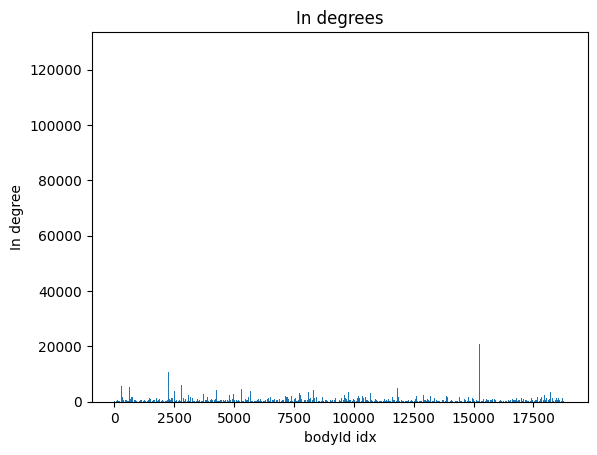

In [32]:
# graphs of indegree, outdegree
import matplotlib.pyplot as plt
plt.bar(range(len(bodyIds)), in_degree)
plt.title('In degrees')
plt.xlabel('bodyId idx')
plt.ylabel('In degree')

Text(0, 0.5, 'In degree')

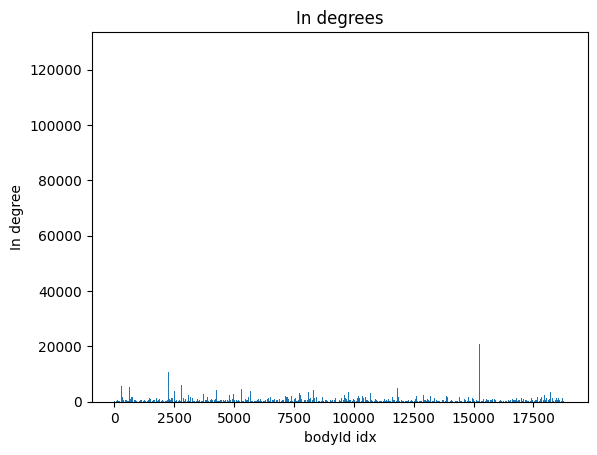

In [35]:
import matplotlib.pyplot as plt
plt.bar(range(len(bodyIds)), in_degree)
plt.title('In degrees')
plt.xlabel('bodyId idx')
plt.ylabel('In degree')

Text(0, 0.5, 'In degree')

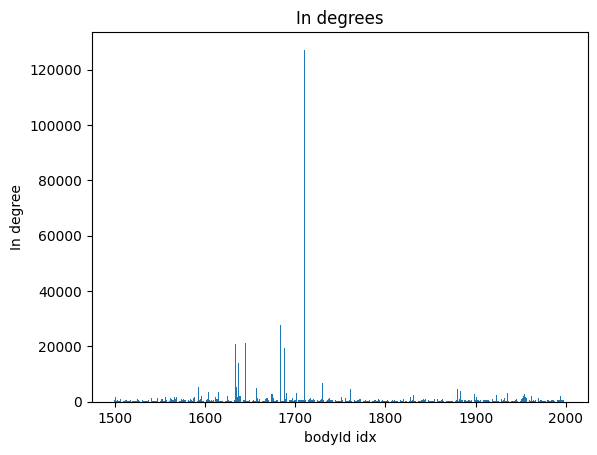

In [33]:
import matplotlib.pyplot as plt
plt.bar(range(1500, 2000), in_degree[1500:2000])
plt.title('In degrees')
plt.xlabel('bodyId idx')
plt.ylabel('In degree')

In [36]:
top_in_idxs = sorted(range(len(bodyIds)), key = lambda x: in_degree[x], reverse = True)[:20]

In [51]:
in_degree[top_in_idxs]

array([127148.,  77269.,  32516.,  30007.,  29221.,  28662.,  27642.,
        27350.,  27110.,  26007.,  23111.,  23052.,  22759.,  21380.,
        21254.,  21195.,  21000.,  20981.,  20616.,  20281.])

Text(0, 0.5, 'in degree')

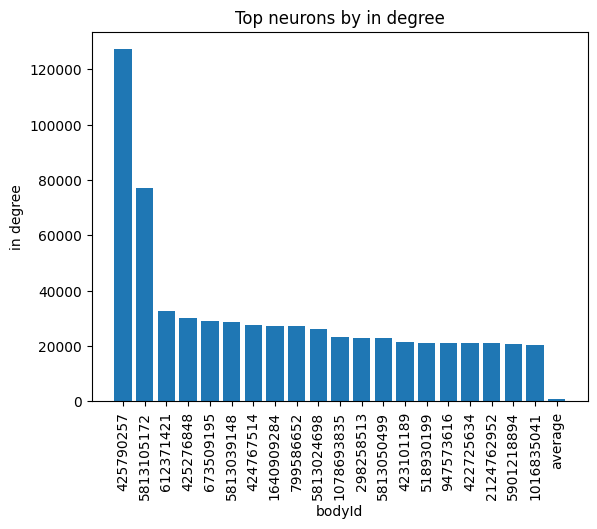

In [54]:
plt.bar([str(bodyIds[idx]) for idx in top_in_idxs] + ['average'], np.concatenate([in_degree[top_in_idxs] , [np.mean(in_degree)]]) )
plt.title('Top neurons by in degree')
plt.xlabel('bodyId')
plt.xticks(rotation = 90)
plt.ylabel('in degree')

In [ ]:
top_in_idxs

[1710,
 18571,
 3471,
 1702,
 4080,
 17337,
 1684,
 13070,
 5347,
 17067,
 8268,
 363,
 17618,
 1645,
 2548,
 6948,
 1634,
 15250,
 18806,
 7655]

In [ ]:
print(in_degree[1710])
print(out_degree[1710]) # this neuron has the most combined in , out degree - I predict it's APL (Got it!!!)
print(bodyIds[1710])
print(traced_neurons[traced_neurons['bodyId'] == bodyIds[1710]])

127148.0
16190.0
425790257
         bodyId instance type
4492  425790257    APL_R  APL


Text(0, 0.5, 'Out degree')

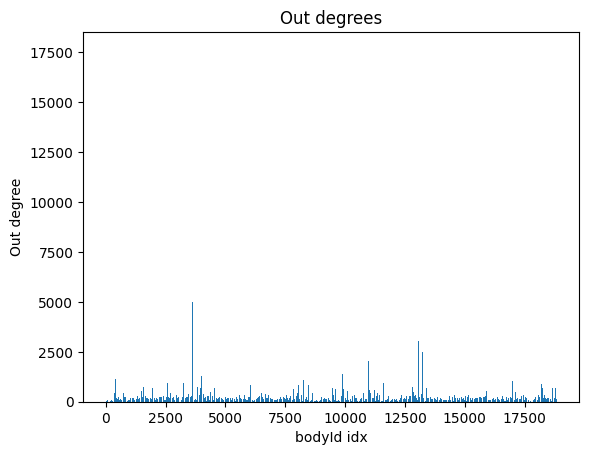

In [61]:
plt.bar(range(len(bodyIds)), out_degree)
plt.title('Out degrees')
plt.xlabel('bodyId idx')
plt.ylabel('Out degree')

Text(0, 0.5, 'Out degree')

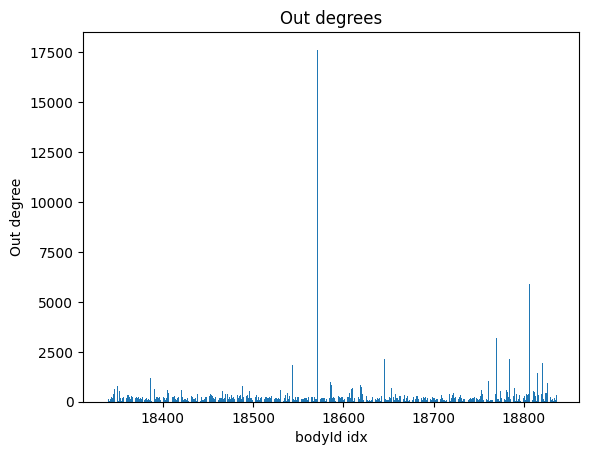

In [62]:
plt.bar(range(len(bodyIds)-500, len(bodyIds)), out_degree[-500:])
plt.title('Out degrees')
plt.xlabel('bodyId idx')
plt.ylabel('Out degree')

In [55]:
,top_out_idxs = sorted(range(len(bodyIds)), key = lambda x: out_degree[x], reverse = True)[:20]

In [58]:
top_out_idxs[:5]

[18571, 1710, 721, 17067, 13070]

In [56]:
out_degree[top_out_idxs]

array([17628., 16190.,  8626.,  8150.,  7997.,  7499.,  7490.,  7281.,
        7088.,  6861.,  6540.,  5875.,  5869.,  5584.,  5226.,  5032.,
        5016.,  4957.,  4812.,  4789.])

In [63]:
print(np.mean(in_degree), np.mean(out_degree))

895.0161915379307 270.40425757817064


Text(0, 0.5, 'out degree')

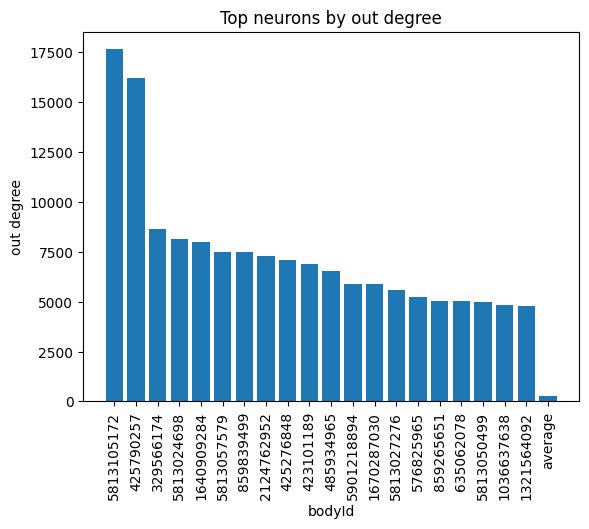

In [57]:
plt.bar([str(bodyIds[idx]) for idx in top_out_idxs] + ['average'], np.concatenate([out_degree[top_out_idxs] , [np.mean(out_degree)]]) )
plt.title('Top neurons by out degree')
plt.xlabel('bodyId')
plt.xticks(rotation = 90)
plt.ylabel('out degree')

In [ ]:
top_out_idxs[0]

18571

In [ ]:
print(bodyIds[18571])
print(in_degree[18571])
print(traced_neurons[traced_neurons['bodyId'] == bodyIds[18571]]) # DPM has the second highest degree

5813105172
77269.0
           bodyId instance type
10712  5813105172    DPM_R  DPM


In [ ]:
# input feature vector: Num_nodes x 5
print(in_degree.shape)
print(xyz.shape)

X = np.zeros((num_nodes, 5))
X[:, 0] = in_degree
X[:, 1] = out_degree
X[:, 2:5] = xyz
print(X.shape)

(18837,)
(18837, 3)
(18837, 5)


In [ ]:
# normalize?

# Network architecture

In [ ]:
class BaselineGNN(nn.Module):
    def __init__(self,
                 num_in_feats,
                 adjacency,
                 num_classes,
                 ):

        super().__init__()

        self.num_in_feats = num_in_feats
        self.A = adjacency
        self.num_classes = num_classes

        self.activation = nn.Sigmoid()
        self.softmax = nn.Softmax()

        _, self.F1, self.F2, self.F3, self.F4, self.F5 = np.geomspace(self.num_in_feats, self.num_classes, 6, dtype = int)

        self.W1 = nn.Linear(self.num_in_feats, self.F1)
        self.W2 = nn.Linear(self.F1, self.F2)
        self.W3 = nn.Linear(self.F2, self.F3)
        self.W4 = nn.Linear(self.F3, self.F4)
        self.W5 = nn.Linear(self.F4, self.F5)



    
    def forward(self, X):
        H1 = self.activation(self.W1(X))
        H2 = self.activation(self.W2(H1))
        H3 = self.activation(self.W3(H2))
        H4 = self.activation(self.W4(H3))
        H5 = self.softmax(self.W5(H4))

        # print(H3.shape)

        return H5

In [ ]:
model = BaselineGNN(5, A_tensor, num_classes)

### Balance out DPM and APL

In [ ]:
X[1710]

array([127148.,  16190.,  16460.,  18318.,   5310.])

In [ ]:
X[1710, 0] = 0 # set to 0 for APL

In [ ]:
X[18571]

array([77269., 17628., 25266., 32639., 13604.])

In [ ]:
X[18571, 0 ] = 0 # set to 0 for DPM

In [ ]:
# normalize stuff?
# note: if we include APL, then in degree will be normalized to 0...
X_normed = np.zeros_like(X)
for i in range(X_normed.shape[1]):
    X_normed[:, i] = X[:, i] / sum(X[:, i])

In [ ]:
Y = nn.functional.one_hot(torch.tensor(labels))

In [ ]:
Y.shape

torch.Size([18837, 4741])

In [ ]:
# separate into test and train
X_tensor = torch.tensor(X_normed).to(torch.float32)
Y = Y.to(torch.float32)

indexes = range(len(X_tensor))

train_indexes = np.random.choice(indexes, 15000)
val_indexes = np.random.choice(indexes, 1000)
test_indexes = indexes
# train_indexes = np.random.choice(indexes, 150)
# val_indexes = np.random.choice(indexes, 100)
# test_indexes = np.random.choice(indexes, 50)

X_train = X_tensor[train_indexes]
Y_train = Y[train_indexes]

X_val = X_tensor[val_indexes]
Y_val = Y[val_indexes]

X_test = X_tensor[test_indexes]
Y_test = Y[test_indexes]

# X_train = X_tensor[:15000]
# Y_train = Y[:15000]

# X_val = X_tensor[15000:16000]
# Y_val = Y[15000:16000]

# X_test = X_tensor[16000:]
# Y_test = Y[16000:]

# Training Loop - Baseline Accuracy

In [ ]:
model = BaselineGNN(5, A_tensor, num_classes)

In [ ]:
optimizer = torch.optim.SGD(
  model.parameters(), lr=1e-4, momentum=0.1
)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

train_accuracies = []
test_accuracies = []
val_accuracies = []


num_epochs = 100
n_batches = 10
batch_size = len(X_train)//n_batches

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for batch in range(n_batches):
        # print(f"batch: {batch}")
        # features = X_train[batch*(batch_size) : (batch+1) * batch_size] # should be random
        # targets = Y_train[batch*(batch_size) : (batch+1) * batch_size]
        # print(features.shape)
        rand_indexes = np.random.choice(len(X_train), size=batch_size) # 
        features   = X_train[rand_indexes]
        # print(features.shape)
        targets = Y_train[rand_indexes]
            
        forward_pass_outputs = model(features)
        loss = loss_fn(forward_pass_outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Loss = {loss}")

    train_outputs = model(X_train)
    train_accuracy = sum(sum(torch.mul(train_outputs, Y_train)) / len(Y_train))
    train_accuracies.append(train_accuracy)
    print(f"Train accuracy = {train_accuracy}")

    val_outputs = model(X_val)
    val_accuracy = sum(sum(torch.mul(val_outputs, Y_val))) / len(Y_val)
    val_accuraccies.append(val_accuracy)
    print(f"Val accuracy = {val_accuracy}")

    test_outputs = model(X_test)
    test_accuracy = sum(sum(torch.mul(test_outputs, Y_test)) / len(Y_test))
    test_accuracies.append(test_accuracy)
    print(f"Test accuracy = {test_accuracy}")



In [ ]:
# note: KCab cells are involved in olfaction (ECBM6070)
csv_synapses[csv_synapses['type'] == 'KCab-s']

,cellBodyFiber,bodyid,pre,post,upstream,downstream,status,statusLabel,cropped,name,...,total_inputs_density,axon_outputs_density,dend_outputs_density,axon_inputs_density,dend_inputs_density,total_length,axon_length,dend_length,pd_length,segregation_index
0,PDL03,5812980768,233,411,411,742,Traced,Roughly traced,False,KCab-s_R,...,0.650109,1.955320,1.200554,0.990357,0.734604,632.201495,118.139233,238.223429,35.604968,0.001535
799,PDL03,612669205,263,542,542,834,Traced,Roughly traced,False,KCab-s_R,...,0.599753,1.532358,0.312533,0.896236,0.570235,890.366445,388.290457,182.380885,241.076154,0.028746
871,PDL04,363733406,225,539,539,727,Traced,Roughly traced,False,KCab-s_R,...,0.568238,1.329161,0.156868,0.838548,0.622241,946.786507,399.500204,191.244192,210.129098,0.064717
919,PDL01,457507485,229,582,582,727,Traced,Roughly traced,False,KCab-s_R,...,0.614657,1.460896,0.277968,0.998005,0.708818,945.243398,304.607612,215.852232,287.775082,0.049813
943,PDL03,5812980611,201,483,483,634,Traced,Roughly traced,False,KCab-s_R,...,0.579244,1.210175,0.265735,0.738265,0.664336,833.845471,345.404622,218.262892,203.333959,0.059441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3490,PDL03,631051012,216,615,615,670,Traced,Roughly traced,False,KCab-s_R,...,0.629009,1.347080,0.172744,0.965316,0.615869,972.959602,366.719226,266.290501,216.587647,0.063489
3515,PDL02,5813110928,207,546,546,653,Traced,Roughly traced,False,KCab-s_R,...,0.584750,1.455773,0.283629,0.969305,0.630287,930.311688,275.455028,222.121167,257.111581,0.044264
3624,PDL01,5813021263,210,616,616,680,Traced,Roughly traced,False,KCab-s_R,...,0.594168,1.301046,0.265825,1.068339,0.519567,1035.061641,378.157211,248.283657,249.652238,0.019054
3654,PDL03,630722830,215,530,530,678,Traced,Roughly traced,False,KCab-s_R,...,0.572111,1.276259,0.393810,0.847124,0.716018,926.393119,358.861309,195.525946,231.454371,0.030714


In [ ]:
csv_synapses[csv_synapses['bodyid'] == 5812980768]

,cellBodyFiber,bodyid,pre,post,upstream,downstream,status,statusLabel,cropped,name,...,total_inputs_density,axon_outputs_density,dend_outputs_density,axon_inputs_density,dend_inputs_density,total_length,axon_length,dend_length,pd_length,segregation_index
0,PDL03,5812980768,233,411,411,742,Traced,Roughly traced,False,KCab-s_R,...,0.650109,1.95532,1.200554,0.990357,0.734604,632.201495,118.139233,238.223429,35.604968,0.001535


In [ ]:
csv_synapses[['X', 'Y', 'Z']]

,X,Y,Z
0,10372.0,12128.0,12116.0
1,8416.0,22008.0,4650.0
2,11448.0,13554.0,9230.0
3,29797.0,31023.0,23871.0
4,19205.0,12326.0,13177.0
...,...,...,...
24688,2644.0,17146.0,8106.0
24689,27750.0,32354.0,8070.0
24690,11479.0,11915.0,14828.0
24691,18248.0,13876.0,9032.0


### Metadata for neurons

In [ ]:
csv = pd.read_csv('data-raw/hemibrain_all_neurons_metrics_polypre_centrifugal_distance.csv')

In [ ]:
# compare to neuron metdata
csv[csv['bodyid'] == 5812980768]

,Unnamed: 0,bodyid,pre,post,status,statusLabel,cropped,name,type,cellBodyFiber,...,axon_outputs_density,dend_outputs_density,axon_inputs_density,dend_inputs_density,total_length,axon_length,dend_length,pd_length,segregation_index,overlap_locality
3326,5812980768,5812980768,233,411,Traced,Roughly traced,False,KCab-s part,KCab-sc,PDL03,...,0.0,0.0,0.0,0.0,630.913334,211.172853,143.037622,60.587129,0.002877,NaN


In [ ]:
csv.head()

,Unnamed: 0,bodyid,pre,post,status,statusLabel,cropped,name,type,cellBodyFiber,...,axon_outputs_density,dend_outputs_density,axon_inputs_density,dend_inputs_density,total_length,axon_length,dend_length,pd_length,segregation_index,overlap_locality
0,202916528,202916528,95,422,Traced,Roughly traced,False,FQ12_b_C4_R,FQ12_b,PDM03,...,0.0,0.0,0.0,0.0,1112.361752,266.682070,597.883459,115.207041,0.760906,NaN
1,1279775082,1279775082,24,140,Traced,Roughly traced,False,FQ12_a(AB)_C1_R,FQ12_a,PDM04,...,0.0,0.0,0.0,0.0,665.584354,142.498728,215.337713,131.953748,0.590056,NaN
2,203253072,203253072,62,352,Traced,Roughly traced,False,FQ12_a_C3_R,FQ12_a,PDM03,...,0.0,0.0,0.0,0.0,872.035917,153.191952,398.862417,185.390775,0.452794,NaN
3,326530038,326530038,383,3030,Traced,Roughly traced,False,PDM22c_pct(PDM22)_R,PDM22c_pct,iPB7,...,0.0,0.0,0.0,0.0,5862.584767,2405.826341,3137.630436,181.975991,0.084045,NaN
4,203253253,203253253,402,2675,Traced,Roughly traced,False,(PDM09)_L,NaN,NaN,...,0.0,0.0,0.0,0.0,5446.304041,2032.027462,3135.417423,141.691472,0.197539,0.310494


In [ ]:
csv.columns

Index(['Unnamed: 0', 'bodyid', 'pre', 'post', 'status', 'statusLabel',
       'cropped', 'name', 'type', 'cellBodyFiber', 'voxels', 'soma',
       'total_outputs', 'total_inputs', 'axon_outputs', 'dend_outputs',
       'axon_inputs', 'dend_inputs', 'total_outputs_density',
       'total_inputs_density', 'axon_outputs_density', 'dend_outputs_density',
       'axon_inputs_density', 'dend_inputs_density', 'total_length',
       'axon_length', 'dend_length', 'pd_length', 'segregation_index',
       'overlap_locality'],
      dtype='object')

In [ ]:
csv[['bodyid', 'type', 'name']]

,bodyid,type,name
0,202916528,FQ12_b,FQ12_b_C4_R
1,1279775082,FQ12_a,FQ12_a(AB)_C1_R
2,203253072,FQ12_a,FQ12_a_C3_R
3,326530038,PDM22c_pct,PDM22c_pct(PDM22)_R
4,203253253,NaN,(PDM09)_L
...,...,...,...
22562,2403140939,NaN,NaN
22563,2311059545,NaN,NaN
22564,2405523662,NaN,NaN
22565,2279976491,NaN,NaN


In [ ]:
csv['overlap_locality'].unique()

array([           nan, 3.10493574e-01, 1.02049763e-10, ...,
       4.37864056e-02, 5.08706645e-07, 2.00402683e-24])

In [ ]:
csv['voxels'].nunique()

22566

In [ ]:
# set up H feature matrix
# H = #num_nodes x num_features

# features: X, Y, Z, in_degree, out_degree

# using GCN
model from https://discuss.dgl.ai/t/how-could-use-edge-or-node-weight/1310/2

In [ ]:
e_weights = torch.tensor(traced_total_connections['weight'].values)#.unsqueeze(-1)

In [ ]:
e_weights.shape

torch.Size([3413160])

In [ ]:
# pylint: disable=W0235
class GraphConv(nn.Module):
    r"""
    Description
    -----------
    Graph convolution was introduced in `GCN <https://arxiv.org/abs/1609.02907>`__
    and mathematically is defined as follows:
    .. math::
      h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_j^{(l)}W^{(l)})
    where :math:`\mathcal{N}(i)` is the set of neighbors of node :math:`i`,
    :math:`c_{ij}` is the product of the square root of node degrees
    (i.e.,  :math:`c_{ij} = \sqrt{|\mathcal{N}(i)|}\sqrt{|\mathcal{N}(j)|}`),
    and :math:`\sigma` is an activation function.

    Parameters
    ----------
    in_feats : int
        Input feature size; i.e, the number of dimensions of :math:`h_j^{(l)}`.
    out_feats : int
        Output feature size; i.e., the number of dimensions of :math:`h_i^{(l+1)}`.
    norm : str, optional
        How to apply the normalizer. If is `'right'`, divide the aggregated messages
        by each node's in-degrees, which is equivalent to averaging the received messages.
        If is `'none'`, no normalization is applied. Default is `'both'`,
        where the :math:`c_{ij}` in the paper is applied.
    weight : bool, optional
        If True, apply a linear layer. Otherwise, aggregating the messages
        without a weight matrix.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.
    activation : callable activation function/layer or None, optional
        If not None, applies an activation function to the updated node features.
        Default: ``None``.
    allow_zero_in_degree : bool, optional
        If there are 0-in-degree nodes in the graph, output for those nodes will be invalid
        since no message will be passed to those nodes. This is harmful for some applications
        causing silent performance regression. This module will raise a DGLError if it detects
        0-in-degree nodes in input graph. By setting ``True``, it will suppress the check
        and let the users handle it by themselves. Default: ``False``.

    Attributes
    ----------
    weight : torch.Tensor
        The learnable weight tensor.
    bias : torch.Tensor
        The learnable bias tensor.

    Note
    ----
    Zero in-degree nodes will lead to invalid output value. This is because no message
    will be passed to those nodes, the aggregation function will be appied on empty input.
    A common practice to avoid this is to add a self-loop for each node in the graph if
    it is homogeneous, which can be achieved by:
    >>> g = ... # a DGLGraph
    >>> g = dgl.add_self_loop(g)
    Calling ``add_self_loop`` will not work for some graphs, for example, heterogeneous graph
    since the edge type can not be decided for self_loop edges. Set ``allow_zero_in_degree``
    to ``True`` for those cases to unblock the code and handle zere-in-degree nodes manually.
    A common practise to handle this is to filter out the nodes with zere-in-degree when use
    after conv.

    Examples
    --------
    >>> import dgl
    >>> import numpy as np
    >>> import torch as th
    >>> from dgl.nn import GraphConv
    >>> # Case 1: Homogeneous graph
    >>> g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
    >>> g = dgl.add_self_loop(g)
    >>> feat = th.ones(6, 10)
    >>> conv = GraphConv(10, 2, norm='both', weight=True, bias=True)
    >>> res = conv(g, feat)
    >>> print(res)
    tensor([[ 1.3326, -0.2797],
            [ 1.4673, -0.3080],
            [ 1.3326, -0.2797],
            [ 1.6871, -0.3541],
            [ 1.7711, -0.3717],
            [ 1.0375, -0.2178]], grad_fn=<AddBackward0>)
    >>> # allow_zero_in_degree example
    >>> g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
    >>> conv = GraphConv(10, 2, norm='both', weight=True, bias=True, allow_zero_in_degree=True)
    >>> res = conv(g, feat)
    >>> print(res)
    tensor([[-0.2473, -0.4631],
            [-0.3497, -0.6549],
            [-0.3497, -0.6549],
            [-0.4221, -0.7905],
            [-0.3497, -0.6549],
            [ 0.0000,  0.0000]], grad_fn=<AddBackward0>)
    >>> # Case 2: Unidirectional bipartite graph
    >>> u = [0, 1, 0, 0, 1]
    >>> v = [0, 1, 2, 3, 2]
    >>> g = dgl.bipartite((u, v))
    >>> u_fea = th.rand(2, 5)
    >>> v_fea = th.rand(4, 5)
    >>> conv = GraphConv(5, 2, norm='both', weight=True, bias=True)
    >>> res = conv(g, (u_fea, v_fea))
    >>> res
    tensor([[-0.2994,  0.6106],
            [-0.4482,  0.5540],
            [-0.5287,  0.8235],
            [-0.2994,  0.6106]], grad_fn=<AddBackward0>)
    """
    def __init__(self,
                 in_feats,
                 out_feats,
                 norm='both',
                 weight=True,
                 bias=True,
                 activation=None,
                 allow_zero_in_degree=False):
        super(GraphConv, self).__init__()
        if norm not in ('none', 'both', 'right'):
            raise DGLError('Invalid norm value. Must be either "none", "both" or "right".'
                           ' But got "{}".'.format(norm))
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._norm = norm
        self._allow_zero_in_degree = allow_zero_in_degree

        if weight:
            self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        else:
            self.register_parameter('weight', None)

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_feats))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

        self._activation = activation

    def reset_parameters(self):
        r"""
        Description
        -----------
        Reinitialize learnable parameters.

        Note
        ----
        The model parameters are initialized as in the
        `original implementation <https://github.com/tkipf/gcn/blob/master/gcn/layers.py>`__
        where the weight :math:`W^{(l)}` is initialized using Glorot uniform initialization
        and the bias is initialized to be zero.
        """
        if self.weight is not None:
            init.xavier_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)

    def set_allow_zero_in_degree(self, set_value):
        r"""
        Description
        -----------
        Set allow_zero_in_degree flag.

        Parameters
        ----------
        set_value : bool
            The value to be set to the flag.
        """
        self._allow_zero_in_degree = set_value

    def forward(self, graph, feat, eweight, weight=None):
        r"""
        Description
        -----------
        Compute graph convolution.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor or pair of torch.Tensor
            If a torch.Tensor is given, it represents the input feature of shape
            :math:`(N, D_{in})`
            where :math:`D_{in}` is size of input feature, :math:`N` is the number of nodes.
            If a pair of torch.Tensor is given, which is the case for bipartite graph, the pair
            must contain two tensors of shape :math:`(N_{in}, D_{in_{src}})` and
            :math:`(N_{out}, D_{in_{dst}})`.
        eweight : torch.Tensor of shape (E, 1)
            Edge weights, E for the number of edges.
        weight : torch.Tensor, optional
            Optional external weight tensor.

        Returns
        -------
        torch.Tensor
            The output feature

        Raises
        ------
        DGLError
            Case 1:
            If there are 0-in-degree nodes in the input graph, it will raise DGLError
            since no message will be passed to those nodes. This will cause invalid output.
            The error can be ignored by setting ``allow_zero_in_degree`` parameter to ``True``.
            Case 2:
            External weight is provided while at the same time the module
            has defined its own weight parameter.

        Note
        ----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.
        * Weight shape: :math:`(\text{in_feats}, \text{out_feats})`.
        """
        with graph.local_scope():
            if not self._allow_zero_in_degree:
                if (graph.in_degrees() == 0).any():
                    raise DGLError('There are 0-in-degree nodes in the graph, '
                                   'output for those nodes will be invalid. '
                                   'This is harmful for some applications, '
                                   'causing silent performance regression. '
                                   'Adding self-loop on the input graph by '
                                   'calling `g = dgl.add_self_loop(g)` will resolve '
                                   'the issue. Setting ``allow_zero_in_degree`` '
                                   'to be `True` when constructing this module will '
                                   'suppress the check and let the code run.')

            # (BarclayII) For RGCN on heterogeneous graphs we need to support GCN on bipartite.
            feat_src, feat_dst = expand_as_pair(feat, graph)
            if self._norm == 'both':
                degs = graph.out_degrees().float().clamp(min=1)
                norm = torch.pow(degs, -0.5)
                shp = norm.shape + (1,) * (feat_src.dim() - 1)
                norm = torch.reshape(norm, shp)
                feat_src = feat_src * norm

            if weight is not None:
                if self.weight is not None:
                    raise DGLError('External weight is provided while at the same time the'
                                   ' module has defined its own weight parameter. Please'
                                   ' create the module with flag weight=False.')
            else:
                weight = self.weight

            # Set edge weights
            graph.edata['w'] = eweight
            if self._in_feats > self._out_feats:
                # mult W first to reduce the feature size for aggregation.
                if weight is not None:
                    feat_src = torch.matmul(feat_src, weight)
                graph.srcdata['h'] = feat_src
                # Changed from fn.copy_src to fn.u_mul_e
                graph.update_all(fn.u_mul_e(lhs_field='h', rhs_field='w', out='m'),
                                 fn.sum(msg='m', out='h'))
                rst = graph.dstdata['h']
            else:
                # aggregate first then mult W
                graph.srcdata['h'] = feat_src
                # Changed from fn.copy_src to fn.u_mul_e
                graph.update_all(fn.u_mul_e(lhs_field='h', rhs_field='w', out='m'),
                                 fn.sum(msg='m', out='h'))
                rst = graph.dstdata['h']
                if weight is not None:
                    rst = torch.matmul(rst, weight)

            if self._norm != 'none':
                degs = graph.in_degrees().float().clamp(min=1)
                if self._norm == 'both':
                    norm = torch.pow(degs, -0.5)
                else:
                    norm = 1.0 / degs
                shp = norm.shape + (1,) * (feat_dst.dim() - 1)
                norm = torch.reshape(norm, shp)
                rst = rst * norm

            if self.bias is not None:
                rst = rst + self.bias

            if self._activation is not None:
                rst = self._activation(rst)

            return rst

In [ ]:
gnn = GraphConv(in_feats = 2, # in degree and out degree
               out_feats = num_classes,
               allow_zero_in_degree = True)

In [ ]:
# add additional parameters

In [ ]:
graph.ndata['feat'] = torch.stack([graph.in_degrees(), graph.out_degrees()]).T

In [ ]:
graph.ndata['train_mask'] = torch.zeros(num_nodes, dtype=bool)

In [ ]:
graph.ndata['test_mask'] = torch.zeros(num_nodes, dtype=bool)
graph.ndata['val_mask'] = torch.zeros(num_nodes, dtype=bool)


In [ ]:
graph.ndata['train_mask'][0:15000] = True
graph.ndata['val_mask'][15000:16000] = True
graph.ndata['test_mask'][16000:] = True

In [ ]:
graph.ndata['label'] = torch.tensor(labels)

In [ ]:
def train(g, model, lr = 0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(100):
        # Forward
        logits = model(g, features, e_weights.to(torch.float32))

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        
#         print(logits[train_mask].squeeze().shape)
#         print(logits[train_mask].squeeze())
#         print(labels[train_mask].shape)
#         print(labels[train_mask])
        
#         loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        loss = F.cross_entropy(logits[train_mask].squeeze(0), labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
                "In epoch {}, loss: {:.3f}, train acc: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
                    e, loss, train_acc, val_acc, best_val_acc, test_acc, best_test_acc
                )
            )


train(graph, gnn)

/home/chenzyu/columbia/sp23/coms6691/pj/env/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 44.112, train acc: 0.000, val acc: 0.000 (best 0.000), test acc: 0.000 (best 0.000)
In epoch 5, loss: 31.630, train acc: 0.018, val acc: 0.016 (best 0.016), test acc: 0.016 (best 0.016)
In epoch 10, loss: 23.862, train acc: 0.010, val acc: 0.008 (best 0.016), test acc: 0.009 (best 0.016)
In epoch 15, loss: 18.382, train acc: 0.002, val acc: 0.004 (best 0.016), test acc: 0.004 (best 0.016)
In epoch 20, loss: 14.554, train acc: 0.002, val acc: 0.004 (best 0.016), test acc: 0.002 (best 0.016)
In epoch 25, loss: 12.460, train acc: 0.027, val acc: 0.023 (best 0.024), test acc: 0.022 (best 0.021)
In epoch 30, loss: 10.892, train acc: 0.016, val acc: 0.016 (best 0.024), test acc: 0.013 (best 0.021)
In epoch 35, loss: 9.754, train acc: 0.020, val acc: 0.018 (best 0.024), test acc: 0.018 (best 0.021)
In epoch 40, loss: 9.337, train acc: 0.021, val acc: 0.020 (best 0.024), test acc: 0.018 (best 0.021)
In epoch 45, loss: 9.063, train acc: 0.019, val acc: 0.019 (best 0.024), test